In [1]:
import numpy as np
import matplotlib.pyplot as plt


### Maximal Planar Subdivision
- a subdivision S is a MPS if addion one edge connecting two vertices of S destroys the planarity of S
- i.e adding an edge intersects at least one existing edge
- If every face is a triangle, then the subdivsion is maximal.
- Let {P} be a set of n points, not all on the same line. Let k be the number of points on the boundary of the convex-hull of {P}. Then, any triangulation of P has (2n-2-k) triangles and (3n-3-k) edges
- If P has no inner poitns of its convex hull, then k = n and then, any triangulation of P has n-2 triangles and 2n-3 edges

### Delaunay Triangulation
- the optimal triangulation maximizes the minimum angle of the triangles
- this prevents sharp triangles. 
- we want our triangles to be as close to equilateral
- A Delaunay triangulation for a given set of discrete points $\{\vec{p}_i\}$ is a set of triangles $\{T_i\}$ such that no point in $\{ \vec{p}_i\}$ is inside the circumcircle of any triangle in $\{ T_i \}$.
- Every point must either be outside/on every circumcircle.
- This ensures every triangle is local, and no triangle "reaches" too far to include distant points. This prevents slender triangles. 

### Algorithm:    
- start by creating an initial super-triangle that contains all the points.
- For each point $\vec{q}_i$:
  - Insert the point $\vec{q}_i$ and check which all circumcircles contains this point. These identify the "bad" triangles. Remove these bad triangles 
  - When the bad triangles are removed, it leaves behind some polygons holes. Connect the vertices of these polygons to the new point $\vec{q}_i$ to create new triangles.
- After inserting the point and forming new triangles, ensure that the Delaunay condition is still satisfied. this involves chcekcing for edge-flips where two triangles share an edge but do not satisfy the delaunay condtion


### Basic implementation of Bowyer Watson algorithm for triangulation
- this is not robust for degenerate points

In [44]:
# Define a Tirangle class 

class Triangle:
    def __init__(self,p1,p2,p3):
        self.points = np.array([p1,p2,p3])
        self.circumcenter,self.circumradius = self.compute_circumcircle()

    def compute_circumcircle(self):
        # returns (center, radius) of circumcircle
        
        A,B,C = self.points[0],self.points[1],self.points[2]
        Ax,Ay = self.points[0]
        Bx,By = self.points[1]
        Cx,Cy = self.points[2]

        D = (Ax * (By - Cy) + Bx * (Cy - Ay) + Cx * (Ay - By)) #determinant
        A2 = Ax**2 + Ay**2
        B2 = Bx**2 + By**2
        C2 = Cx**2 + Cy**2
        
        ux = 0.5 * (A2 * (By - Cy) + B2 * (Cy - Ay) + C2 * (Ay - By)) / D
        uy = 0.5 * (A2 * (Cx - Bx) + B2 * (Ax - Cx) + C2 * (Bx - Ax)) / D

        center = np.array([ux, uy])

        # length of sides AB,BC,AC
        a = np.linalg.norm(B - C) 
        b = np.linalg.norm(C - A)
        c = np.linalg.norm(A - B)

        # s = (a + b + c) / 2 # semi-perimeter of triangle
        # area = np.sqrt(s * (s - a) * (s - b) * (s - c)) # Herons formula for area of triangle
        
        area = np.abs(D)/2
        radius = (a * b * c) / (4 * area) # Circumradius formula
        
        return (center,radius)


    def contains_point(self, point):
        # Check if the point is inside the circumcircle of this triangle.
        center = self.circumcenter
        radius = self.circumradius
        if np.linalg.norm(center - point) < radius: 
            return True
        return False
        

In [69]:
def bowyer_watson(points):
    # simple 2D Delaunay triangulation

    # supertriangle (large enough to contain all points)
    minx,miny = np.min(points, axis=0)
    maxx,maxy = np.max(points, axis=0)
    dx,dy = maxx-minx, maxy-miny
    delta = max(dx,dy)
    midx,midy = (minx+maxx)/2, (miny+maxy)/2

    p1 = midx - 20*delta, midy - delta
    p2 = midx , midy + 20*delta
    p3 = midx + 20*delta, midy - delta
    
    super_triangle = Triangle(p1,p2,p3)

    triangles = [super_triangle]
    
    # iterate over points
    for p in points:
        bad_triangles = []
        # iterate over all triangles/circumcircles
        for tri in triangles: 
            if tri.contains_point(p):
                bad_triangles.append(tri)

        # find boundary edge of polygon hole
        boundary_edges = []
        for tri in bad_triangles:
            for i in range(3):
                edge = tuple(sorted((tuple(tri.points[i]), tuple(tri.points[(i+1)%3]))))
                if edge in boundary_edges:
                    boundary_edges.remove(edge) # this is a shared edge
                else:
                    boundary_edges.append(edge)

        # remove bad triangles
        triangles = [tri for tri in triangles if tri not in bad_triangles]

        # create new triangles
        for edge in boundary_edges:
            new_tri = Triangle(np.array(edge[0]), np.array(edge[1]), p)
            triangles.append(new_tri)

    # remove any triangles that contain super-triangle vertices
    triangles = [tri for tri in triangles if not np.any(np.isin(tri.points, [p1, p2, p3]))]

    return triangles


### Example

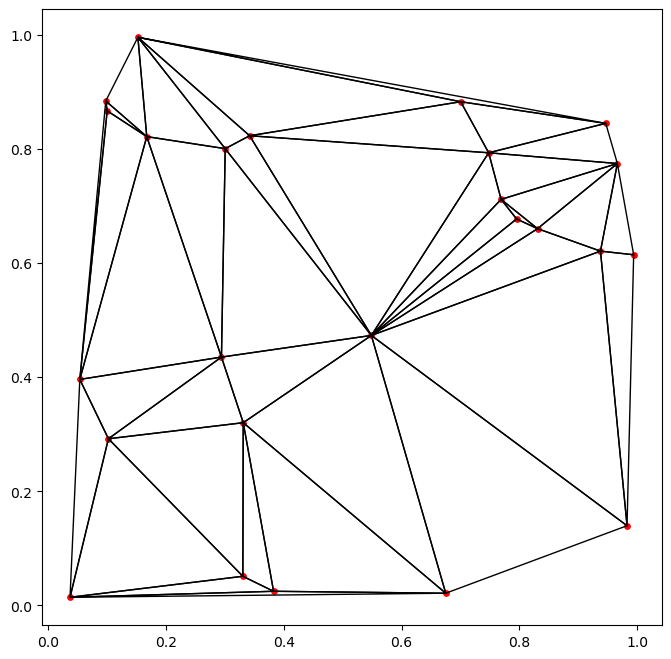

In [123]:
# Example Usage:
points = np.random.rand(25, 2)  # Random points
triangles = bowyer_watson(points)

# Plot 
plt.figure(figsize=(8, 8))

# plot all points
for pt in points:
    plt.scatter(pt[0],pt[1],color='r',s=15)

# plot all triangles
for triangle in triangles:
    Ax,Ay = triangle.points[0]
    Bx,By = triangle.points[1]
    Cx,Cy = triangle.points[2]
    plt.plot([Ax,Bx,Cx,Ax],[Ay,By,Cy,Ay],'k-',lw=1)

plt.show()

-----------------------------

### Example - Regular grid of points

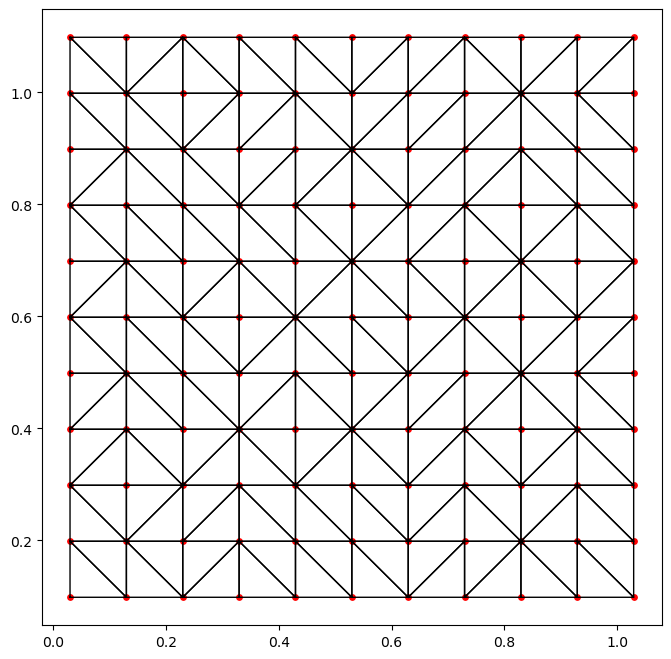

In [121]:
# Example usage - regular grid of points with some noise 
# i added some noise to deal with rounding off errors 

x = np.linspace(0,1,11) + np.random.random()/20
y = np.linspace(0,1,11) + np.random.random()/10
X,Y = np.meshgrid(x,y)
points = np.vstack([X.ravel(), Y.ravel()]).T
triangles = bowyer_watson(points)

# Plot 
plt.figure(figsize=(8, 8))

# plot all points
for pt in points:
    plt.scatter(pt[0],pt[1],color='r',s=15)

# plot all triangles
for triangle in triangles:
    Ax,Ay = triangle.points[0]
    Bx,By = triangle.points[1]
    Cx,Cy = triangle.points[2]
    plt.plot([Ax,Bx,Cx,Ax],[Ay,By,Cy,Ay],'k-',lw=1)

plt.show()